In [9]:
#Basic imports
import numpy as np
import pandas as pd
import pickle

#sklearn imports
from sklearn.decomposition import PCA #Principal Component Analysis
from sklearn.manifold import TSNE #T-Distributed Stochastic Neighbor Embedding
from sklearn.cluster import KMeans #K-Means Clustering
from sklearn.preprocessing import StandardScaler #used for 'Feature Scaling'

import ast

from nltk import ngrams

from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch # for dendogram

#sklearn imports
from sklearn.decomposition import PCA #Principal Component Analysis
from sklearn.manifold import TSNE #T-Distributed Stochastic Neighbor Embedding
from sklearn.cluster import KMeans #K-Means Clustering
from sklearn.preprocessing import StandardScaler #used for 'Feature Scaling'

#plotly imports
import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot


In [2]:
df = pd.read_csv('./data_TM2/processed/processed_utterances_sentence_DA_labeling.csv', index_col=0)

## Create input in correct format (one hot) for clustering later

#### First identify all possible unigrams, bigrams and trigrams

In [3]:
all_DA = []
for row in range(len(df['all_DA'])):
    inst = ast.literal_eval(df['all_DA'][row])
    inst = [i.strip("[]") for i in inst]
    all_DA.append(inst)
    
df['all_DA'] = all_DA

df.drop(df.iloc[:, 8:-1], inplace = True, axis = 1)
df = df.explode('all_DA')
df['all_DA'] = df['all_DA'].fillna('<UNK>')

In [4]:
unique = list(df['all_DA'].unique())
one_hot_ubtf = []

#uni
[one_hot_ubtf.append([x]) for x in unique]
one_hot_ubtf

#bi
for i in range(len(unique)):
    for j in range(len(unique)):
        one_hot_ubtf.append([unique[i], unique[j]])
        
#tri >>>>>> until here 12,719
for i in range(len(unique)):
    for j in range(len(unique)):
        for k in range(len(unique)):
            one_hot_ubtf.append([unique[i], unique[j], unique[k]])
            
# #four >>>>>>> from here 292,560 variables
# for i in range(len(unique)):
#     for j in range(len(unique)):
#         for k in range(len(unique)):
#             for l in range(len(unique)):
#                 one_hot_ubtf.append([unique[i], unique[j], unique[k], unique[l]])

len(one_hot_ubtf)

12719

#### Now get patterns identified by HMM or baseline

In [5]:
### now use results from HMM, i.e the detected patterns to make a one hot. 
# list os lists, each sublist is one pattern found in the HMM

a_file = open('./src/generated_files/sorted_hmm_dict.pkl', "rb") #'./src/generated_files/hmm_results.pkl'
hmm_results = pickle.load(a_file)


In [6]:
hmm_patterns = []
for key in hmm_results.keys():
    hmm_patterns.append(key.split())
    
hmm_patterns = hmm_patterns[1:]

#### Now make uni, bi, tri found in each pattern

In [7]:
print(len(hmm_patterns))

#remove unigram patterns found in hmm, since they can't be considered patterns
for pat in hmm_patterns:
    if len(pat) == 1:
        hmm_patterns.remove(pat)
        
print(len(hmm_patterns))

25536
25521


In [10]:
dict_grams = {}

for e, pat in enumerate(hmm_patterns):
    pat = (' ').join(pat)
    
    for uni in ngrams(pat.split(), 1):
        uni = list(uni)
        if pat not in dict_grams:
            dict_grams[pat] = [uni]
        else:
            dict_grams[pat].extend([uni])
        
    for bi in ngrams(pat.split(), 2):
        bi = list(bi)
        if pat not in dict_grams:
            dict_grams[pat] = [bi]
        dict_grams[pat].extend([bi])

    for tri in ngrams(pat.split(), 3):
        tri = list(tri)
        if pat not in dict_grams:
            dict_grams[pat] = [tri]
        dict_grams[pat].extend([tri])

# dict_grams

# #sanity check
# len(hmm_patterns) == len(dict_grams.keys())

#### Create matrix of zeros and populate it with 1 if one of the values of each key is found (i.e a uni,bi or tri per pattern)
matrix >> rows are patterns and columns are all possible uni, bi, trigrams

In [11]:
# create matrix size len(one_hot_ubtf) X len(hmm_results)
one_hot_mat = np.zeros((len(dict_grams.keys()), len(one_hot_ubtf))) #format: mat_one_hot[row=dict_grams.keys][column_one_hot]

In [12]:
# one_hot_mat_exemplo = np.zeros((len(dict_grams_exemplo.keys()), len(one_hot_ubtf_exemplo)))
# one_hot_ubtf_exemplo = [['U_answer'], ['NADA2'],  ['A_detail_request'], ['U_answer', 'A_detail_request'],
#                        ['A_completion_check'], ['A_completion_check', 'A_detail_request'], ['NADA1']]
# dict_grams_exemplo = {'ex0':[['U_answer'], ['A_detail_request'], ['U_answer', 'A_detail_request']],
#                       'ex1':[['A_completion_check'], ['A_detail_request'], ['A_completion_check', 'A_detail_request']]}


for e, pattern in enumerate(dict_grams.values()):
    for g, pat in enumerate(pattern):
#         print(g, pat)
        for f, pos_ngr in enumerate(one_hot_ubtf):
            if pos_ngr == pat:
                one_hot_mat[e][f] = 1

one_hot_mat[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [13]:
#sanity check to see if there are at least same number of 1s then pattern. (pattern can be bigger cause DA can repeat, but never smaller)
values = dict_grams.values()
values = list(values)

pat_n = 10000
one_hot_mat[pat_n].sum() <= (len(values[pat_n]))

True

In [ ]:
with open('./src/generated_files/one_hot_mat_HMM.pkl', 'wb') as fp:
    pickle.dump(one_hot_mat, fp)
    

## Clustering

In [14]:
# Import required packages
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [15]:
#select adequate number for K
#https://blog.cambridgespark.com/how-to-determine-the-optimal-number-of-clusters-for-k-means-clustering-14f27070048f 

Sum_of_squared_distances = []

K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(one_hot_mat[:5000])
    Sum_of_squared_distances.append(km.inertia_) # from K_means > inertia_: float: Sum of squared distances of samples to their closest cluster center, weighted by the sample weights if provided.

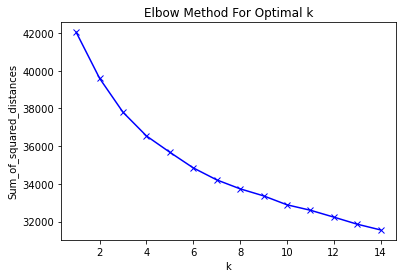

In [16]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')

plt.savefig('./src/generated_files/Optimal_k_for_kmeans.png')
plt.show()



In [17]:
#i won't be able to see anything relevant with this many examples (25k)
# dendrogram = sch.dendrogram(sch.linkage(one_hot_mat, method='ward'))

In [18]:
#Initialize our model with correct number of clusters:

kmeans = KMeans(n_clusters=7)

#Fit our model
kmeans.fit(one_hot_mat)

#Find which cluster each data-point belongs to
clusters = kmeans.predict(one_hot_mat)

# #Add the cluster vector to our DataFrame, X
# # X["Cluster"] = clusters

len(clusters) == len(one_hot_mat)

True

In [ ]:
plot_df = pd.DataFrame(one_hot_mat)
plot_df['Cluster'] = list(clusters)
plot_df['patterns'] = list(dict_grams.keys())

with open('./src/generated_files/df_one_hot_with_cluster_assignment.pkl', 'wb') as fp:
    pickle.dump(plot_df, fp)
    

In [36]:
plot_df.head()

,0,1,2,3,4,5,6,7,8,9,...,12711,12712,12713,12714,12715,12716,12717,12718,Cluster,patterns
0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,U_answer A_detail_request
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,A_completion_check A_detail_request
2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,A_greeting A_detail_request
3,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,A_greeting A_greeting A_detail_request
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,A_grant U_partial_request


In [40]:
plot_df['Cluster'].min()

0

In [37]:
#sampling 
#plotX is a DataFrame containing 5000 values sampled randomly from X
# plot_df = pd.DataFrame(np.array(df_to_cluster.sample(5000)))

#Rename plotX's columns since it was briefly converted to an np.array above
# plot_df.columns = df_to_cluster.columns

# plot_df.head()

In [ ]:
#Set our perplexity
perplexity = 50

#T-SNE with two dimensions
tsne_2d = TSNE(n_components=2, perplexity=perplexity)

# #T-SNE with three dimensions
# tsne_3d = TSNE(n_components=3, perplexity=perplexity)

#This DataFrame contains two dimensions, built by T-SNE
TCs_2d = pd.DataFrame(tsne_2d.fit_transform(plot_df.drop(["Cluster"], axis=1)))

# #And this DataFrame contains three dimensions, built by T-SNE
# TCs_3d = pd.DataFrame(tsne_3d.fit_transform(df_to_cluster.drop(["Cluster"], axis=1)))

#"TC1_2d" means: 'The first component of the components created for 2-D visualization, by T-SNE.'
#And "TC2_2d" means: 'The second component of the components created for 2-D visualization, by T-SNE.'
TCs_2d.columns = ["TC1_2d","TC2_2d"]

# TCs_3d.columns = ["TC1_3d","TC2_3d","TC3_3d"]

df_to_cluster = pd.concat([plot_df,TCs_1d,TCs_2d,TCs_3d], axis=1, join='inner')


#Each of these new DataFrames will hold all of the values contained in exacltly one of the clusters. For example, all of the values contained within the DataFrame, cluster0 will belong to 'cluster 0', and all the values contained in DataFrame, cluster1 will belong to 'cluster 1', etc.

cluster0 = plot_df[plot_df["Cluster"] == 0]
cluster1 = plot_df[plot_df["Cluster"] == 1]
cluster2 = plot_df[plot_df["Cluster"] == 2]
cluster3 = plot_df[plot_df["Cluster"] == 3]
cluster4 = plot_df[plot_df["Cluster"] == 4]
cluster5 = plot_df[plot_df["Cluster"] == 5]
cluster6 = plot_df[plot_df["Cluster"] == 6]


In [ ]:
#Instructions for building the 2-D plot

#trace0 is for 'Cluster 0'
trace0 = go.Scatter(
                    x = cluster0["TC1_2d"],
                    y = cluster0["TC2_2d"],
                    mode = "markers",
                    name = "Cluster 0",
                    marker = dict(color = 'rgba(255, 128, 255, 0.8)'),
                    text = None)

#trace1 is for 'Cluster 1'
trace1 = go.Scatter(
                    x = cluster1["TC1_2d"],
                    y = cluster1["TC2_2d"],
                    mode = "markers",
                    name = "Cluster 1",
                    marker = dict(color = 'rgba(255, 128, 2, 0.8)'),
                    text = None)

#trace2 is for 'Cluster 2'
trace2 = go.Scatter(
                    x = cluster2["TC1_2d"],
                    y = cluster2["TC2_2d"],
                    mode = "markers",
                    name = "Cluster 2",
                    marker = dict(color = 'rgba(0, 255, 10, 0.8)'),
                    text = None)

#trace3 is for 'Cluster 3'
trace3 = go.Scatter(
                    x = cluster2["TC1_2d"],
                    y = cluster2["TC2_2d"],
                    mode = "markers",
                    name = "Cluster 3",
                    marker = dict(color = 'rgba(0, 255, 20, 0.8)'),
                    text = None)

#trace4 is for 'Cluster 4'
trace4 = go.Scatter(
                    x = cluster2["TC1_2d"],
                    y = cluster2["TC2_2d"],
                    mode = "markers",
                    name = "Cluster 4",
                    marker = dict(color = 'rgba(0, 255, 30, 0.8)'),
                    text = None)

#trace5 is for 'Cluster 5'
trace5 = go.Scatter(
                    x = cluster2["TC1_2d"],
                    y = cluster2["TC2_2d"],
                    mode = "markers",
                    name = "Cluster 5",
                    marker = dict(color = 'rgba(0, 255, 40, 0.8)'),
                    text = None)

#trace6 is for 'Cluster 6'
trace6 = go.Scatter(
                    x = cluster2["TC1_2d"],
                    y = cluster2["TC2_2d"],
                    mode = "markers",
                    name = "Cluster 6",
                    marker = dict(color = 'rgba(0, 255, 50, 0.8)'),
                    text = None)



data = [trace0, trace1, trace2, trace3, trace4, trance5, trance6]

title = "Visualizing Clusters in Two Dimensions Using T-SNE (perplexity=" + str(perplexity) + ")"

layout = dict(title = title,
              xaxis= dict(title= 'TC1',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'TC2',ticklen= 5,zeroline= False)
             )

fig = dict(data = data, layout = layout)

iplot(fig)